# Assignments 1 & 2

Obtain the 200 top-ranking universities in www.topuniversities.com ([ranking 2018](https://www.topuniversities.com/university-rankings/world-university-rankings/2018)). In particular, extract the following fields for each university: name, rank, country and region, number of faculty members (international and total) and number of students (international and total). Some information is not available in the main list and you have to find them in the details page. Store the resulting dataset in a pandas DataFrame. 

By aggregating data in following ways:
* by country
* by region

answer which are the best universities in terms of: 
* ratio between faculty members and students
* ratio of international students

Plot your data using bar charts and describe briefly what you observed.

Repeat previous analysis with data available on the 200 top-ranking universities in www.timeshighereducation.com ([ranking 2018](http://timeshighereducation.com/world-university-rankings/2018/world-ranking)). Discuss briefly what you observed.

### Libraries

In [ ]:
import difflib, re, requests, unidecode
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from bs4 import BeautifulSoup as bs
from IPython.core import display as ICD # Used to display multiple dataframes from same cell
import difflib, re, unidecode


### Constants

In [65]:
pd.options.mode.chained_assignment = None

# URLs
TOP_UNIVERSITIES_BASE_URL = 'https://www.topuniversities.com'
TOP_UNIVERSITIES_RANKNING_URL = 'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051.txt?_=1507982846110'
TIMES_HIGHER_EDUCATION_BASE_URL = 'https://www.timeshighereducation.com'
TIMES_HIGHER_EDUCATION_RANKING_URL = 'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'

# Columns in data frames
TOTAL_STAFF_COUNT = 'total_staff_count'
INTERNATIONAL_STAFF_COUNT = 'international_staff_count'
TOTAL_STUDENT_COUNT = 'total_student_count'
INTERNATIONAL_STUDENT_COUNT = 'international_student_count'

### Helper functions

In [66]:
def form_region_dictionary(items, country_key, region_key):
    dictionary = {}
    for item in items:
        # If region is present, update it's contents if needed
        if (item[region_key] in dictionary) and (item[country_key] not in dictionary[item[region_key]]):
            dictionary[item[region_key]].append(item[country_key])
        # If region is not present, create it and put first item
        elif item[region_key] not in dictionary:
            dictionary[item[region_key]] = [item[country_key]]
    return dictionary

def add_region(item, country_key, region_dictionary, default_value='Unknown'):
    result = item.copy()
    result['region'] = default_value
    
    for region, countries in region_dictionary.items():
        if result[country_key] in countries:
            result['region'] = region
            break
    
    return result

def percentage_from_string(word):
    perc = word.strip()
    if perc[-1:] == '%':
        perc = perc[:-1]
    return float(perc) / 100

def int_from_string(word):
    return int("".join(i for i in list(word.strip()) if i.isdigit()))

def float_from_string(word):
    return float("".join(i for i in list(word.strip()) if i.isdigit() or i=='.'))

### Helper functions particular to information obtained from 'Top Universities' ranking site

In [67]:
def tu_parse_ranking(json):
    return list(map(lambda wrapper: { 
            'country' : wrapper['country'],
            'name' : wrapper['title'], 
            'rank' : wrapper['rank_display'], 
            'region' : wrapper['region'],
            'url' : wrapper['url']
        }, json))

def tu_staff_and_students(university):    
    UNI_URL = TOP_UNIVERSITIES_BASE_URL + university['url']
    r = requests.get(UNI_URL)
    
    soup = bs(r.text, 'html.parser')
    result = university.copy()
    
    # Total faculty staff count
    total_staff_wrapper = soup.find('div', class_='total faculty')
    total_staff_count = 0
    
    if total_staff_wrapper:
        total_staff_count = int_from_string(total_staff_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STAFF_COUNT] = total_staff_count
    
    # International faculty staff count
    international_staff_wrapper = soup.find('div', class_='inter faculty')
    international_staff_count = 0
    
    if international_staff_wrapper:
        international_staff_count = int_from_string(international_staff_wrapper.find('div', class_='number').text)

    result[INTERNATIONAL_STAFF_COUNT] = international_staff_count
    
    # Total students count
    total_student_wrapper = soup.find('div', class_='total student')
    total_student_count = 0
    
    if total_student_wrapper:
        total_student_count = int_from_string(total_student_wrapper.find('div', class_='number').text)
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    
    # International students count
    international_student_wrapper = soup.find('div', class_='total inter')
    international_student_count = 0
    
    if international_student_wrapper:
        international_student_count = int_from_string(international_student_wrapper.find('div', class_='number').text)
    
    result[INTERNATIONAL_STUDENT_COUNT] = international_student_count
    
    return result


### Helper functions particular to information obtained from 'Times Higher Education' ranking site

*Note:* 'Times Higher Education' ranking site does not provide information on international staff members. For this reason, values in resulting 'the_df' data frame have value 0 associated with international staff count for all universities.

In [68]:
def the_parse_ranking(json):
    return list(map(lambda wrapper: {
            'country' : wrapper['location'],
            'name' : wrapper['name'],
            'rank' : wrapper['rank'],
            'url' : wrapper['url']
        }, json))

def the_staff_and_students(university):
    UNI_URL = TIMES_HIGHER_EDUCATION_BASE_URL + university['url']
    r = requests.get(UNI_URL)

    soup = bs(r.text, 'html.parser')
    result = university.copy()

    pane = soup.find('div', class_='panel-pane pane-data-stats')
    elements = pane.find_all('li')
    
    international_student_perc = None
    staff_to_student_ratio = None
    total_student_count = None
    
    for element in elements:
        # International student percentage        
        if element.find('div', class_='keystats pc_intl_students') != None:
            international_student_perc_text = element.find('div', class_='value').text
            international_student_perc = percentage_from_string(international_student_perc_text)
        # Total faculty staff ratio
        elif element.find('div', class_='keystats student_staff_ratio') != None:
            staff_to_student_ratio_text = element.find('div', class_='value').text
            staff_to_student_ratio = float_from_string(staff_to_student_ratio_text)
        # Total student count
        elif element.find('div', class_='keystats number_students') != None:
            total_student_count_text = element.find('div', class_='value').text
            total_student_count = int_from_string(total_student_count_text)
    
    result[TOTAL_STAFF_COUNT] = int(total_student_count / staff_to_student_ratio)
    
    # There is no data avilable on international staff count
    result[INTERNATIONAL_STAFF_COUNT] = 0
    
    result[TOTAL_STUDENT_COUNT] = total_student_count
    result[INTERNATIONAL_STUDENT_COUNT] = int(total_student_count * international_student_perc)
        
    return result

### Data retrieval

#### Retrieving data from 'Top Universities' ranking site and forming data frame

In [69]:
r = requests.get(TOP_UNIVERSITIES_RANKNING_URL)
response_json = r.json()['data'][:200]

universities = tu_parse_ranking(response_json)
universities = list(map(tu_staff_and_students, universities))

tu_df = pd.DataFrame.from_dict(universities)

#### Constructing region dictionary

In the next part of the exercise we will retrieve data from 'Times Higher Education' university ranking website which does not have region information coupled with inofrmation about the universities. We can solve this problem by forming 'region dictionary' whose keys will be regions introduced in 'Top Universities' data frame, and whose values will be countries associated with said regions and which were also introduced in 'Top Universities' data frame.

In [70]:
region_dictionary = form_region_dictionary(response_json, 'country', 'region')

Furthermore, we will manually add two more countries to the region dictionary that are not present in the 'Top Universities' data frame, and which are present in 'Times Higher Education' data frame. These countries are Russian Federation and Luxembourg, both being associated with the European region.

In [71]:
region_dictionary['Europe'].append('Russian Federation')
region_dictionary['Europe'].append('Luxembourg')

#### Retrieving data from 'Times Higher Education' ranking site and forming data frame

In [72]:
r = requests.get(TIMES_HIGHER_EDUCATION_RANKING_URL)
response_json = r.json()['data'][:200]

universities = the_parse_ranking(response_json)
universities = list(map(lambda u: add_region(u, 'country', region_dictionary), universities))
universities = list(map(the_staff_and_students, universities))

the_df = pd.DataFrame.from_dict(universities)

#### Adjusting ranks in data frames

Dataframes which we obtained from both ranking sites contain ranks which are not unique to every univeristy. Cases exist where serveral universities share the same rank. We will adjust this and make the rank unique to each university in each dataframe, by respecting original ordering in which univerities appeared on respective ladders.

In [73]:
tu_df['rank'] = range(1, len(tu_df['rank']) + 1)
the_df['rank'] = range(1, len(the_df['rank']) + 1)

#### Preserving obtained ranking infromation

We will save obtained data frames in binary files to avoid recrawling both ranking sites during the rest of the research.

In [74]:
the_df.to_pickle("the_dataset")
tu_df.to_pickle("tu_dataset")

We proceed with reading from saved files for the rest of the research.

In [ ]:
the_df = pd.read_pickle("the_dataset")
tu_df = pd.read_pickle("tu_dataset")

## Top Universities data

#### Exploring the data

We will answer the following questions for the www.topuniversities.com dataset:

 - Which are the best universities in terms of:
     1. ratio between faculty members and students
     2. ratio of international students

We also show the same statistics per country and per region

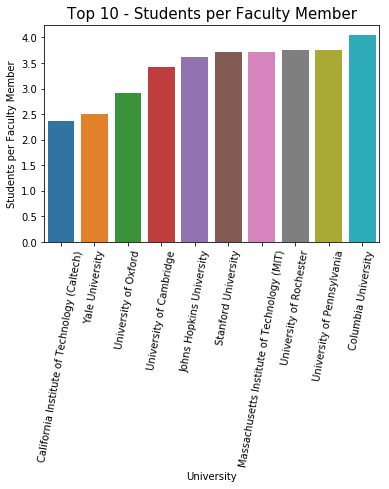

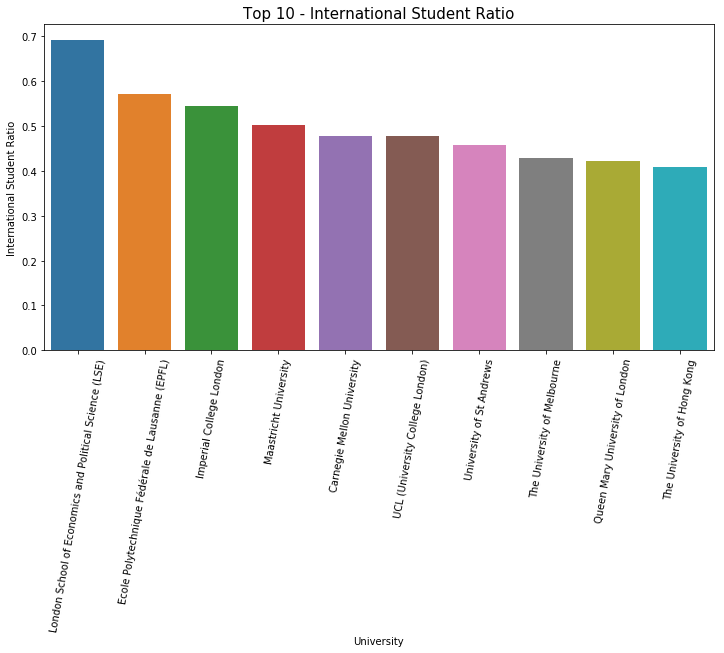

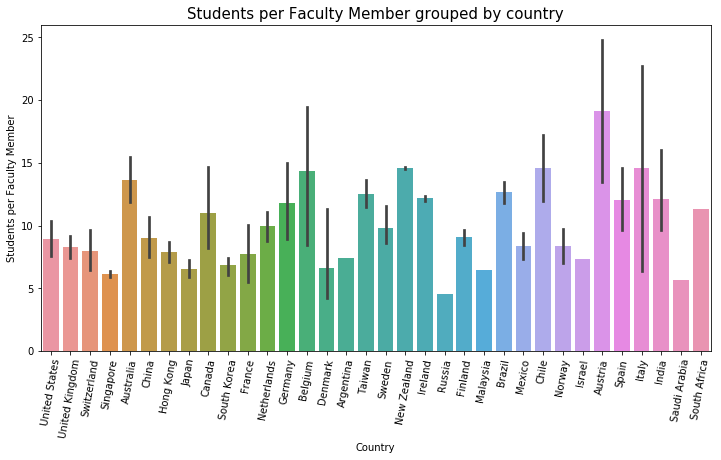

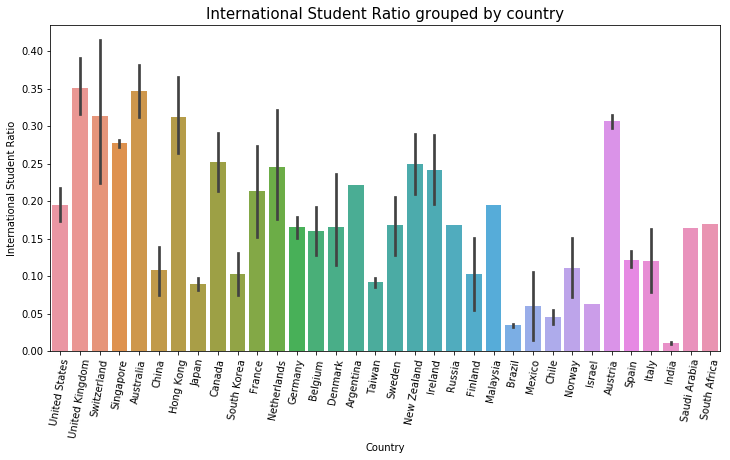

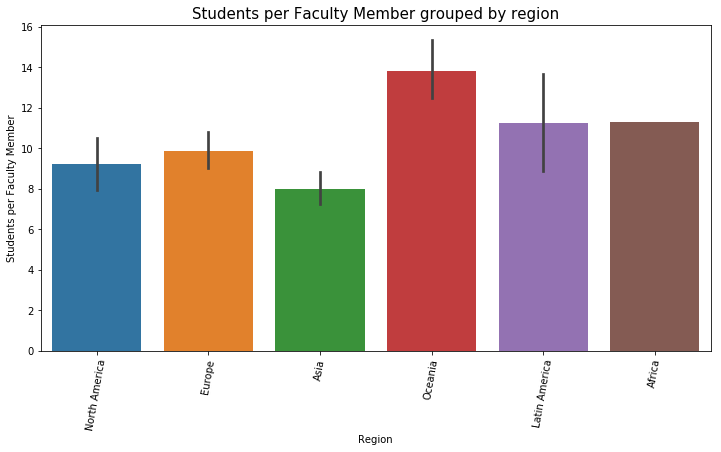

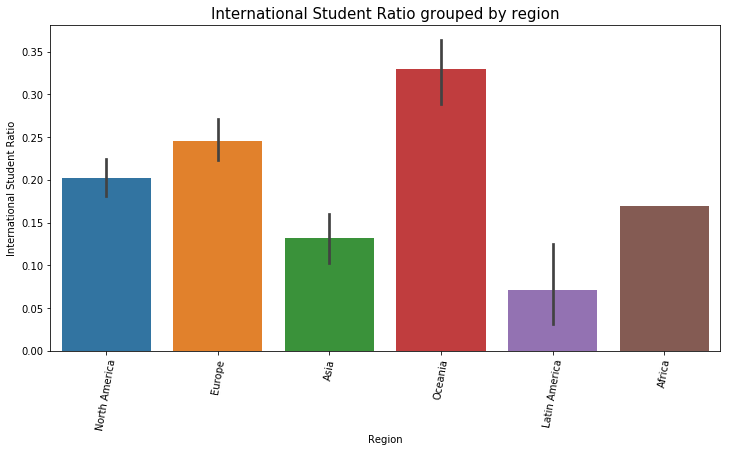

In [76]:
plot_labels = {
    'total_student_count': 'Students per Faculty Member',
    'international_student_count': 'International Student Ratio',
    'country': 'Country',
    'region' : 'Region'
}

def plot_ratio(df, stat, groupby=None, print_table=False):
    # create plot
    fig, ax = plt.subplots()
    
    # calculate ratio
    if stat == 'staff':
        asc = True
        col_name = plot_labels['total_student_count']
        ratio = df['total_student_count'].div(df['total_staff_count'])
    elif stat == 'int':
        asc = False
        col_name = plot_labels['international_student_count']
        ratio = df['international_student_count'].div(df['total_student_count'])

    if groupby is not None:
        title = col_name + " grouped by " + groupby
        
        # create new dataframe
        fsr = pd.concat([df[groupby], ratio], axis=1)
        lbl = plot_labels[groupby]
        fsr.columns = [lbl, col_name]
        fsr_g = fsr.groupby([lbl])[col_name].mean().to_frame()
        fsr_g['std'] = fsr.groupby([lbl])[col_name].std().to_frame()
        #fsr_g.sort_values(by=fsr_g.index, inplace=True, ascending=asc)
        if print_table:
            ICD.display(fsr_g)
        sns.barplot(x=lbl, y=col_name, data=fsr, ax=ax)
    else:
        title = "Top 10 - " + col_name
        
        # create new dataframe
        fsr = pd.concat([df.name, ratio], axis=1)
        fsr.columns = ['University', col_name]
        fsr = fsr.sort_values(by=col_name, ascending=asc)[:10]
        if print_table:
            ICD.display(fsr)
        sns.barplot(fsr['University'], fsr[col_name], ax=ax)

    ax.set_title(title, fontsize=15)
    plt.rcParams['figure.figsize']=(12,6)
    plt.xticks(rotation=80)
    plt.ylabel(col_name)
    return plt

# tu plots
plot_ratio(tu_df, 'staff').show()
plot_ratio(tu_df, 'int', ).show()
plot_ratio(tu_df, 'staff', 'country').show()
plot_ratio(tu_df, 'int', 'country').show()
plot_ratio(tu_df, 'staff', 'region').show()
plot_ratio(tu_df, 'int', 'region').show()

## Times Higher Education data

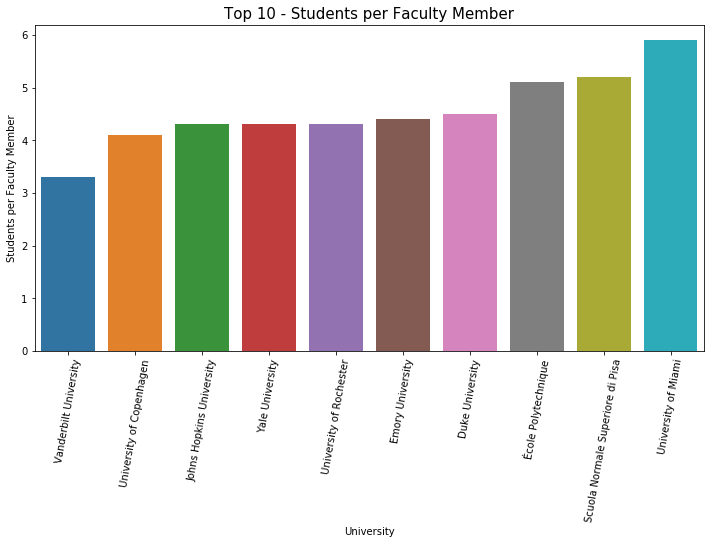

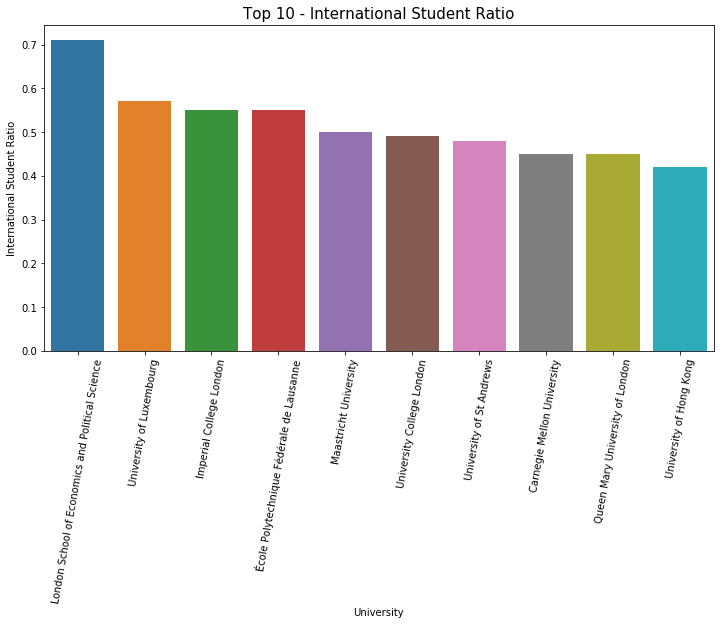

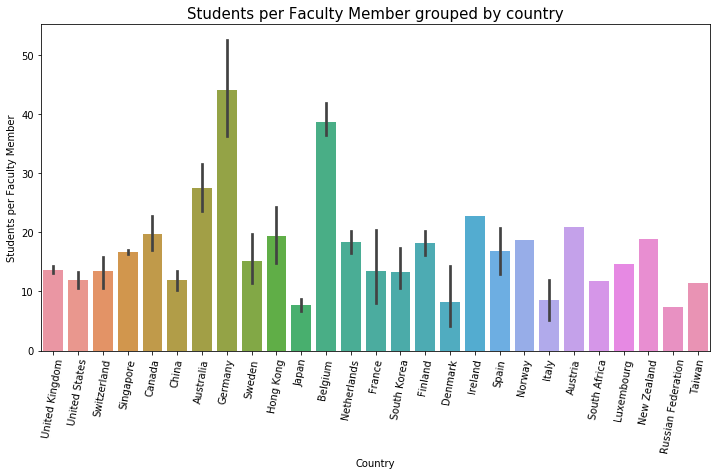

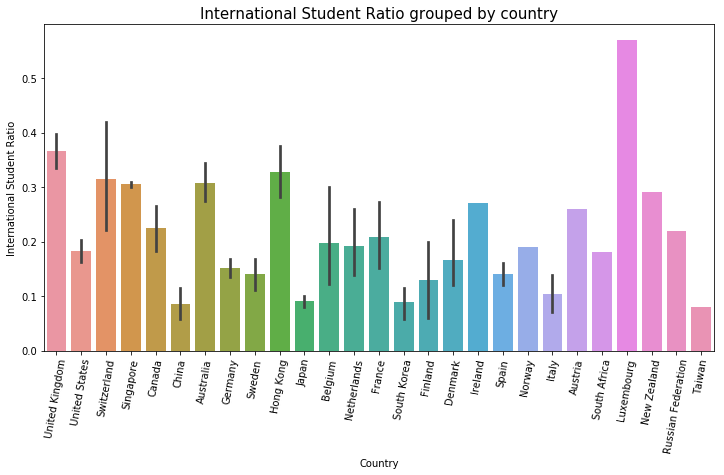

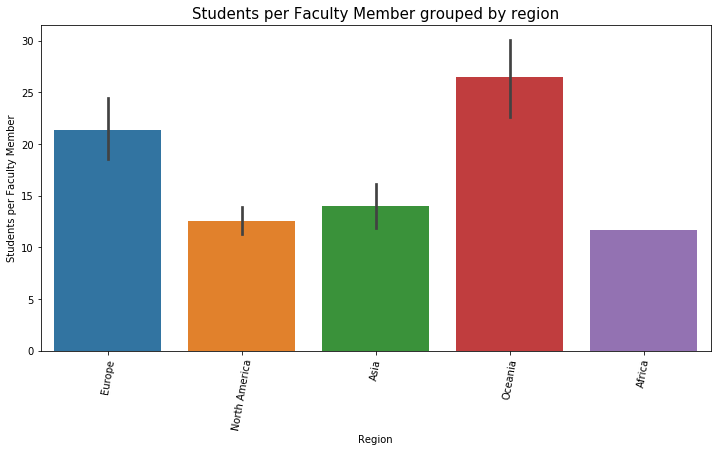

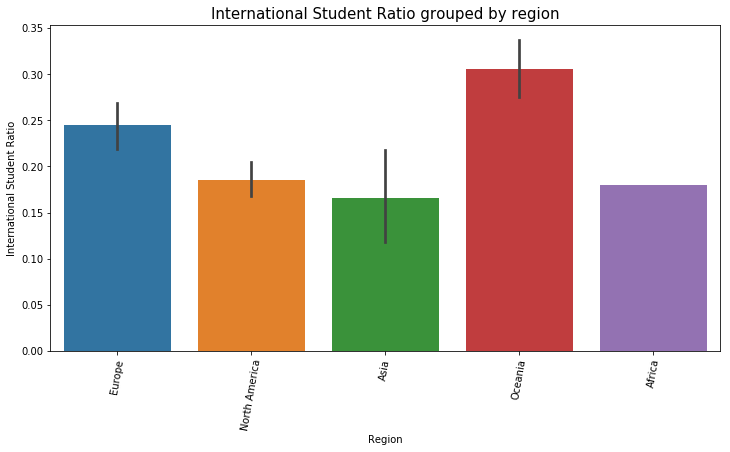

In [77]:
# the plots
plot_ratio(the_df, 'staff').show()
plot_ratio(the_df, 'int', ).show()
plot_ratio(the_df, 'staff', 'country').show()
plot_ratio(the_df, 'int', 'country').show()
plot_ratio(the_df, 'staff', 'region').show()
plot_ratio(the_df, 'int', 'region').show()

#### Matching entries by name

Let us look at the universities that are present in both data sets. Some are present in both rankings, and some are unique to either ranking. We should make sure that each university only occurs once in each dataset to avoid Problems when matching the two sets. 

In [78]:
tu_names_unique = len(set(tu_df['name'])) == len(list(tu_df['name']))
the_names_unique = len(set(the_df['name'])) == len(list(the_df['name']))

print("University names of tu_df are uniqe: {}".format(tu_names_unique))
print("University names of the_df are uniqe: {}".format(the_names_unique))

University names of tu_df are uniqe: True
University names of the_df are uniqe: True


The names of the universities are unique. Now let us find out how many are identical in both datasets.

In [ ]:
# University names for both rankings
the_names = set(the_df.name)
tu_names = set(tu_df.name)

# University names present in both data sets
in_both = the_names.intersection(tu_names)
print("Number of universities in both rankings: {}".format(len(in_both)))

# University names only present in the_names
only_in_the = the_names.difference(tu_names)
print("Number of universities only in the_names: {}".format(len(only_in_the)))

# University names only present in tu_names
only_in_tu = tu_names.difference(the_names)
print("Number of universities only in tu_names: {}".format(len(only_in_tu)))

Number of universities in both rankings: 105
Number of universities only in the_names: 95
Number of universities only in tu_names: 95


In [ ]:
def get_word_frequencies(university_names):
    freqs = {}
    for name in university_names:
        for word in name.split(' '):
            if word in freqs:
                freqs[word] += 1
            else:
                freqs[word] = 1
    return {k: v for k, v in freqs.items() if v > 2}
    
word_freq_dict = get_word_frequencies(only_in_the.union(only_in_tu))
common_words = ['University', 'Science',  'Technology', 'The', 'College', 
                'Institute', '–',  'National', 'Ecole', 'Polytechnique', 
                'and', 'Universidad', '-', 'State', 
                'Université', '&']
#print(sorted(word_freq_dict.items(), key=lambda x:x[1]))
print(word_freq_dict.keys())

def clean_string(string):
    # replace unicode by ascii
    string = unidecode.unidecode(string)
    # remove common words
    for word in common_words:
        string = string.replace(word, '')
    # sort words lexicographically
    string = ' '.join(sorted(string.split(' ')))
    return string

def find_matches(word, words):
    lookup = {}
    word = clean_string(word)
    cleaned = set()
    for entry in words:
        temp = clean_string(entry)
        cleaned.add(temp)
        lookup[temp] = entry
    return lookup, difflib.get_close_matches(word, cleaned, n=1, cutoff=0.7)

def create_matching_dict():
    matching_dict = {}
    count = 0
    for word in list(only_in_the):
        lookup, matches = find_matches(word, only_in_tu)
        if matches:
            count += 1
            matching_dict[word] = lookup[matches[0]]
    print(count)
    return matching_dict

def patch_df(df):
    df_c = df.copy()
    matching_dict = create_matching_dict()
    for i, name in enumerate(df_c.name):
        if name in matching_dict:
            df_c.name[i] = matching_dict[name]
    return df_c

matching_dict = create_matching_dict()
for match in matching_dict:
    print(match + " -> " + matching_dict[match])

dict_keys(['University', 'of', 'de', 'Barcelona', 'Science', 'Technology', 'The', 'Sydney', 'College', 'London', 'California,', 'Indian', 'Institute', 'Zurich', '–', 'National', 'Berlin', 'Tokyo', 'Ecole', 'Polytechnique', 'Western', 'Hong', 'Kong', 'and', 'Dublin', 'New', 'di', 'Universidad', 'Korea', '-', 'Massachusetts', 'State', 'Santa', 'Paris', 'Université', '&', 'Singapore'])
44
University of Auckland -> The University of Auckland
University College London -> King's College London
University of California, San Diego -> University of California, San Diego (UCSD)
ETH Zurich – Swiss Federal Institute of Technology Zurich -> ETH Zurich - Swiss Federal Institute of Technology
National Taiwan University -> National Taiwan University (NTU)
Hong Kong University of Science and Technology -> The Hong Kong University of Science and Technology
Washington University in St Louis -> Washington University in St. Louis
University of Sydney -> University of Technology Sydney
University of Adelaid

In [81]:
merged_df = pd.merge(patch_df(the_df), tu_df, how='inner', on=['name', 'region'], suffixes=('_the', '_tu'))
merged_df

,country_the,international_staff_count_the,international_student_count_the,name,rank_the,region,total_staff_count_the,total_student_count_the,url_the,country_tu,international_staff_count_tu,international_student_count_tu,rank_tu,total_staff_count_tu,total_student_count_tu,url_tu
0,United Kingdom,0,7755,University of Oxford,1,Europe,1822,20409,/world-university-rankings/university-oxford,United Kingdom,2964,7353,6,6750,19720,/universities/university-oxford
1,United Kingdom,0,6436,University of Cambridge,2,Europe,1687,18389,/world-university-rankings/university-cambridge,United Kingdom,2278,6699,5,5490,18770,/universities/university-cambridge
2,United States,0,596,California Institute of Technology (Caltech),3,North America,339,2209,/world-university-rankings/california-institut...,United States,350,647,4,953,2255,/universities/california-institute-technology-...
3,United States,0,3485,Stanford University,4,North America,2112,15845,/world-university-rankings/stanford-university,United States,2042,3611,2,4285,15878,/universities/stanford-university
4,United States,0,3800,Massachusetts Institute of Technology (MIT),5,North America,1284,11177,/world-university-rankings/massachusetts-insti...,United States,1679,3717,1,2982,11067,/universities/massachusetts-institute-technolo...
5,United States,0,8292,Massachusetts Institute of Technology (MIT),191,North America,4453,59230,/world-university-rankings/university-massachu...,United States,1679,3717,1,2982,11067,/universities/massachusetts-institute-technolo...
6,United States,0,5284,Harvard University,6,North America,2283,20326,/world-university-rankings/harvard-university,United States,1311,5266,3,4350,22429,/universities/harvard-university
7,United States,0,1909,Princeton University,7,North America,958,7955,/world-university-rankings/princeton-university,United States,246,1793,13,1007,8069,/universities/princeton-university
8,United Kingdom,0,8721,Imperial College London,8,Europe,1390,15857,/world-university-rankings/imperial-college-lo...,United Kingdom,2071,8746,8,3930,16090,/universities/imperial-college-london
9,United States,0,3381,University of Chicago,9,North America,2181,13525,/world-university-rankings/university-chicago,United States,635,3379,9,2449,13557,/universities/university-chicago


# Assignment 4

Find useful insights in the data by performing an exploratory analysis. Can you find a strong correlation between any pair of variables in the dataset you just created? Example: when a university is strong in its international dimension, can you observe a consistency both for students and faculty members?

#### Manipulating data

Before starting further analysis, we decided to add to our dataset two new columns: first is the ratio between the number of international students and the international staff for each university, and second is the ratio between the total number of students and the total staff count for each university. 

First ratio is being computed only for the dataset with 'Top Universities' ranking information, since 'Times Higher Education' dataset is missing necessary information regarding international staff count as stated earlier. 

Moreover, we decided to discard the column regarding international staff count from the 'Times Higher Education' dataframe, because it would be meaningless to perform any correlation computation with this attribute. Furthermore, we have transformed  'region' attribute to a numerical one in order to try to find a correlation with the other variables.

#### Prepairing 'Top Universities' data

In [82]:
tu_df['international_staff_student_ratio'] = tu_df.international_student_count/tu_df.international_staff_count
tu_df['total_staff_student_ratio'] = tu_df.total_student_count/tu_df.total_staff_count

tur_df = tu_df.copy()
tur_df['region'] = tur_df.region.replace({'Europe': 0, 'North America': 1, 'Asia': 2, 'Oceania': 3, 'Latin America': 4, 'Africa': 5})

#### Prepairing 'Times Higher Education' data

In [83]:
the_df['total_staff_student_ratio'] = the_df.total_student_count/the_df.total_staff_count

ther_df = the_df.copy()
ther_df['region'] = ther_df.region.replace({'Europe': 0, 'North America': 1, 'Asia': 2, 'Oceania': 3, 'Unknown': 4, 'Africa': 5})
ther_df = ther_df.drop(['international_staff_count'], axis=1)

We will be calculating correlation between numerical variables in our datasets. Before, we can make certain assumptions and see how they hold up after our analysis:

* number of students is positively correlated with the number of staff members and with the number of international students 
* number of international students is positively correlated with the number international staff members
* ranking should be positively correlated with the number of students
* ranking should be positively correlated with the number of international students
* ranking should be positively correlated with the student/staff ratios we introduced earlier
* there should be no correlation between rank and region

Regarding last point, any type of correlation between rank and region would signal bias in ranking algorithm that these ranking websites have towards certain regions.

#### Correlation information regarding 'Top Universities' data

In [84]:
tur_df.corr()

,international_staff_count,international_student_count,rank,region,total_staff_count,total_student_count,international_staff_student_ratio,total_staff_student_ratio
international_staff_count,1.000000,0.646589,-0.531141,0.033634,0.596562,0.318303,-0.313711,-0.300527
international_student_count,0.646589,1.000000,-0.302378,0.048427,0.476709,0.562818,0.012382,0.196067
rank,-0.531141,-0.302378,1.000000,-0.063218,-0.308296,-0.033159,0.261191,0.373665
region,0.033634,0.048427,-0.063218,1.000000,0.208480,0.270792,-0.097057,0.049980
total_staff_count,0.596562,0.476709,-0.308296,0.208480,1.000000,0.767160,-0.165532,-0.266912
total_student_count,0.318303,0.562818,-0.033159,0.270792,0.767160,1.000000,0.054530,0.331206
international_staff_student_ratio,-0.313711,0.012382,0.261191,-0.097057,-0.165532,0.054530,1.000000,0.324914
total_staff_student_ratio,-0.300527,0.196067,0.373665,0.049980,-0.266912,0.331206,0.324914,1.000000


#### Correlation information regarding 'Times Higer Education' data

In [85]:
ther_df.corr()

,international_student_count,rank,region,total_staff_count,total_student_count,total_staff_student_ratio
international_student_count,1.000000,-0.328642,0.155380,0.275584,0.578362,0.137570
rank,-0.328642,1.000000,-0.153276,-0.247216,-0.151142,0.107090
region,0.155380,-0.153276,1.000000,0.225605,0.213274,-0.141796
total_staff_count,0.275584,-0.247216,0.225605,1.000000,0.568346,-0.431892
total_student_count,0.578362,-0.151142,0.213274,0.568346,1.000000,0.256495
total_staff_student_ratio,0.137570,0.107090,-0.141796,-0.431892,0.256495,1.000000


Looking at the results, we notice that the corellation between rank positions and the data we obtained is stronger in 'Top Universities' data frame, rather then in 'Times Higher Education' data frame. From that we can deduce that the two website use significantly different ranking models. 

However the highest, as regarding the rank, is in the tu dataset( international_staff_count/rank -0.53) and it's weaker then our expectation.

#### Data visualization 

In this section we will try to obtain more information from our data with the help of plots, such as pairplots and boxplots. Pairplots are useful in visualising the strength of correlation, while boxplots can help us visualize different distributions between certain data types.

#### Pairplot with 'Top Universities' data

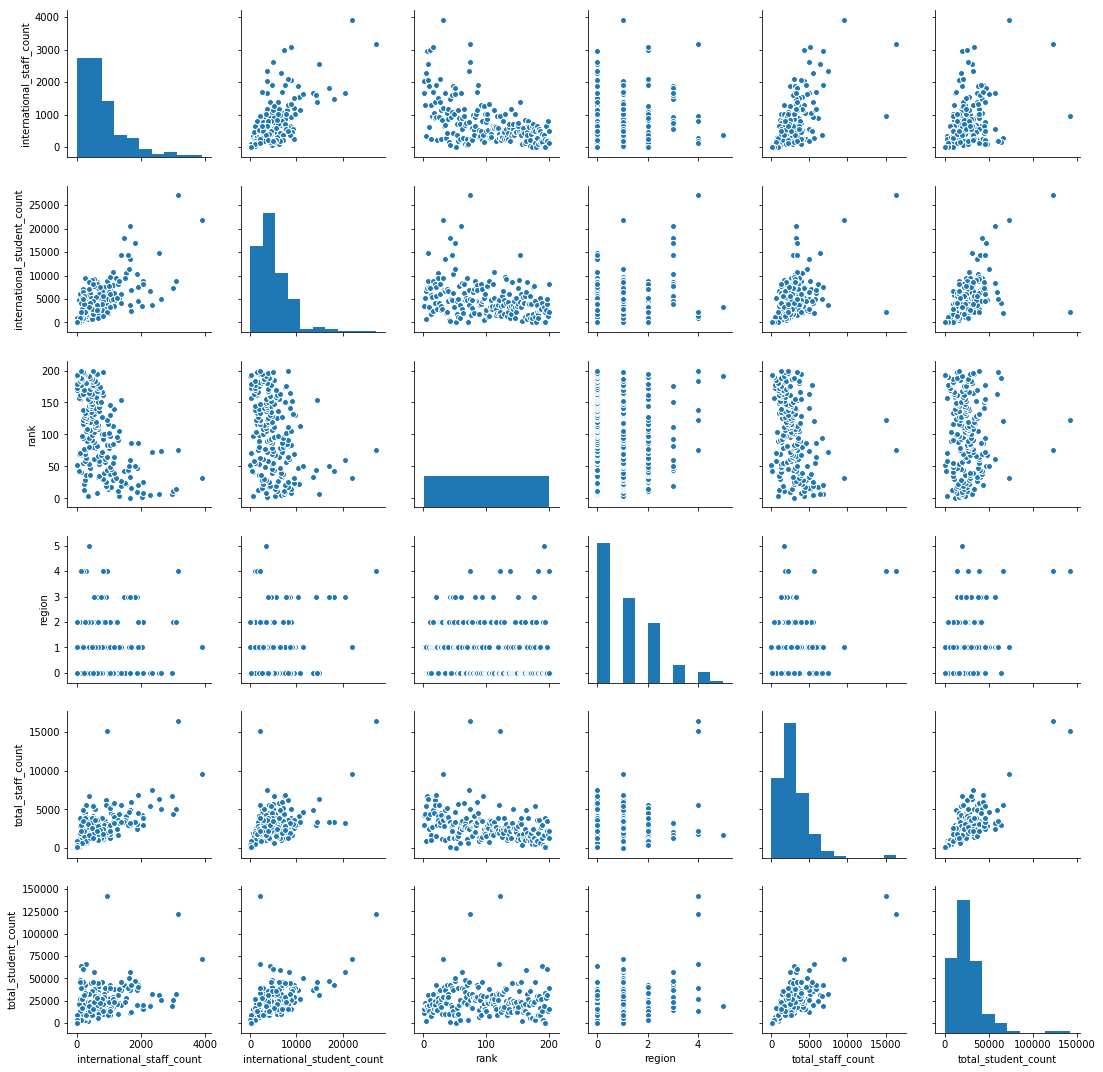

In [87]:
tur_df=tur_df.drop(['international_staff_student_ratio', 'total_staff_student_ratio'], axis=1)
sns.pairplot(tur_df)

#### Pairplot with 'Times Higher Education' data

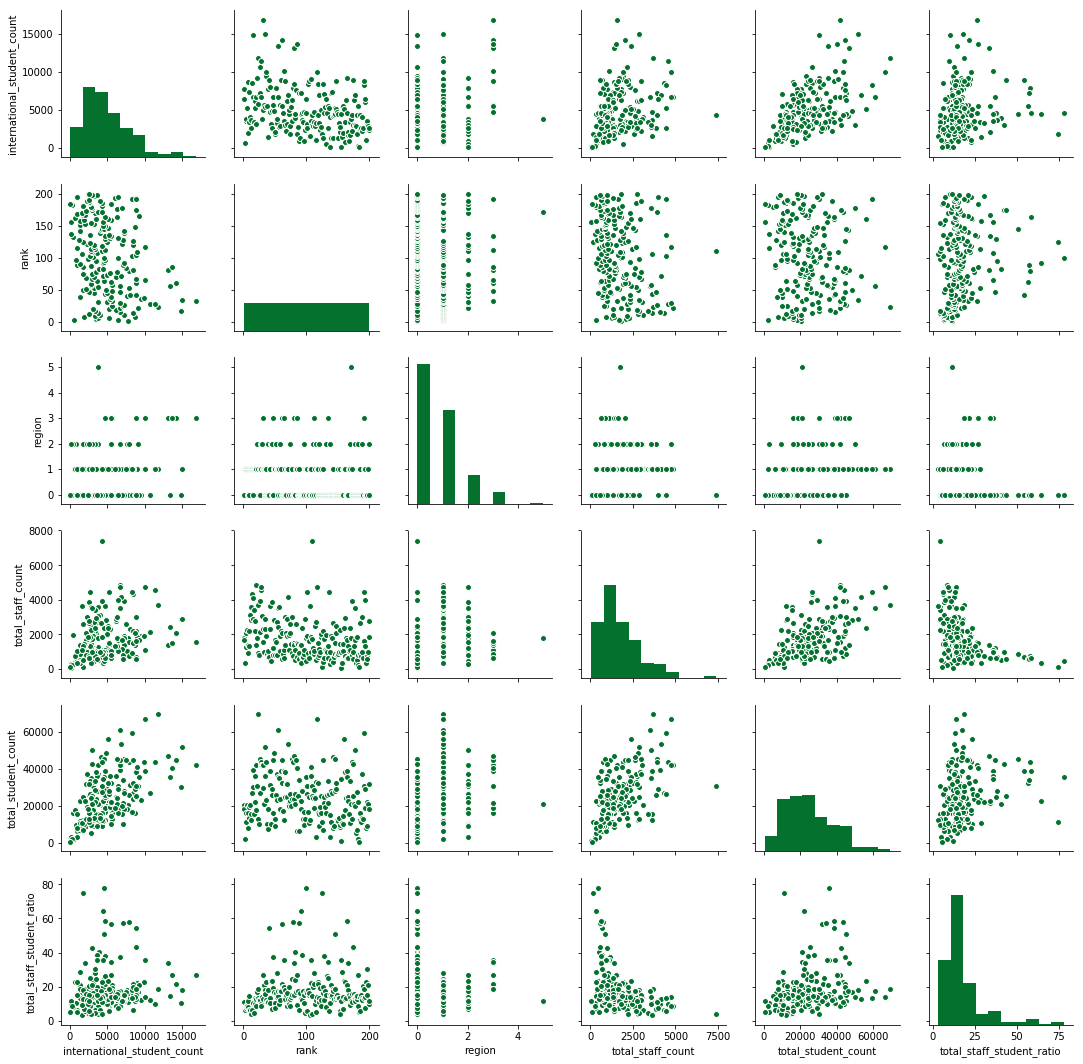

In [88]:
with sns.color_palette("BuGn_r"):
    sns.pairplot(ther_df )

#### Boxplot with 'Top Universities' data

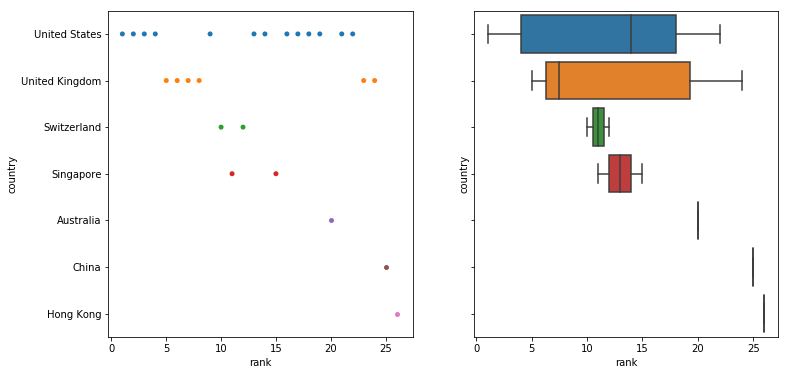

In [89]:
tur_df=tu_df.loc[:25]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.stripplot(x="rank", y="country", data=tur_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=tur_df, ax=ax2);

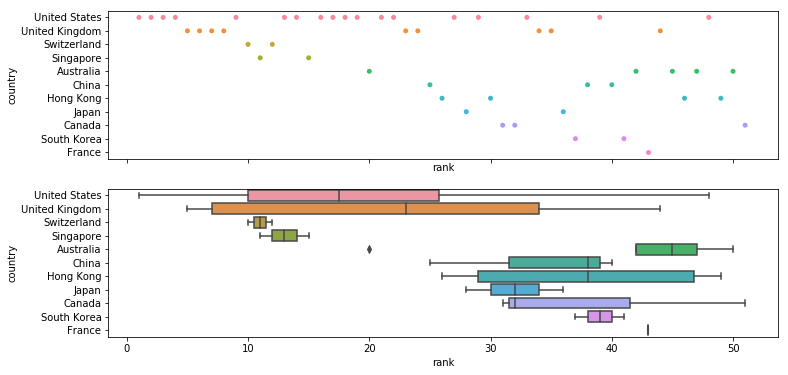

In [90]:
tur_df=tu_df.loc[:50]
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

sns.stripplot(x="rank", y="country", data=tur_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=tur_df, ax=ax2);

#### Boxplot with 'Times Higher Education' data

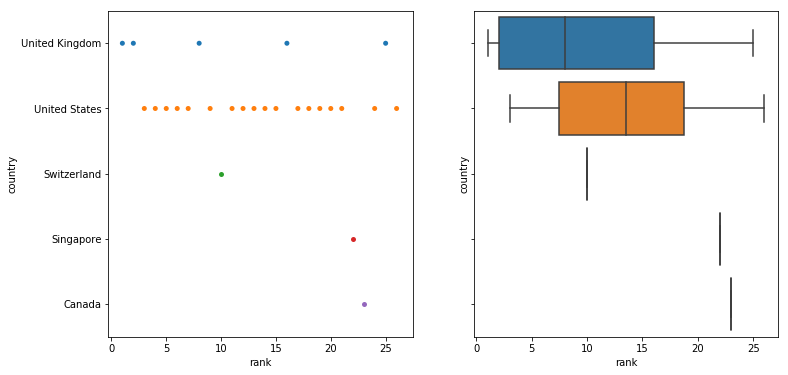

In [91]:
ther_df=the_df.loc[:25]
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

sns.stripplot(x="rank", y="country", data=ther_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=ther_df, ax=ax2);

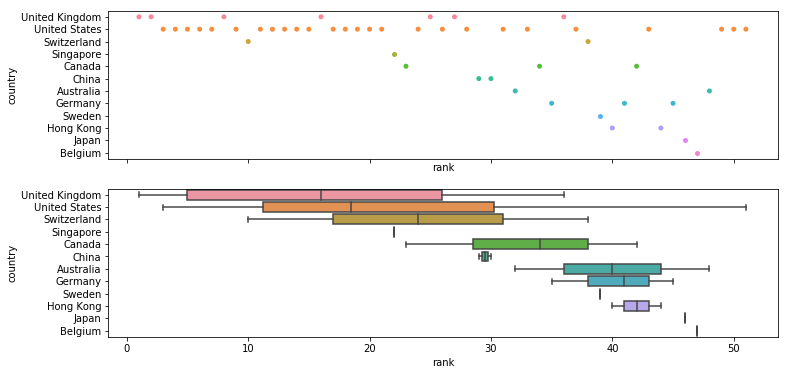

In [92]:
ther_df=the_df.loc[:50]
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)

sns.stripplot(x="rank", y="country", data=ther_df, ax=ax1);
sns.boxplot(x="rank", y="country", data=ther_df, ax=ax2);